In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Exploratory Data Analysis

In [69]:
# df = pd.read_csv("datasets/winequality-red.csv", delimiter=";")
df = pd.read_csv("datasets/weatherAUS_clean.csv")
df = df.drop(columns=["Unnamed: 0"])

In [70]:
# no strange outliers
df.describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_E,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_E,WindDir3pm_W,RainTomorrow
count,121790.000000,121790.000000,121790.000000,121790.000000,121790.000000,121790.000000,121790.000000,121790.00000,121790.000000,121790.000000,...,121790.000000,121790.000000,121790.000000,121790.000000,121790.000000,121790.000000,121790.000000,121790.000000,121790.000000,121790.0
mean,12.392117,23.442506,2.356095,13.407811,7.488602,40.686542,15.029888,19.20739,67.685705,50.798990,...,1.562846,1.580598,1.514377,1.522596,1.382429,1.381509,1.609254,1.443485,1.565753,0.0
std,6.336322,7.140863,8.482433,9.921268,2.807379,13.390520,8.321005,8.58712,19.058076,20.939237,...,1.966491,2.016462,1.929320,1.924537,1.872716,1.882703,1.942573,1.882713,1.961487,0.0
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,7.000000,2.000000,2.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,7.800000,18.100000,0.000000,4.000000,7.200690,31.000000,9.000000,13.00000,56.000000,36.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,12.200000,23.000000,0.000000,9.000000,7.200690,39.000000,13.000000,19.00000,69.000000,51.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,17.000000,28.500000,0.800000,24.666201,9.100000,48.000000,20.000000,24.00000,82.000000,65.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.0
max,33.900000,48.100000,367.600000,82.400000,14.500000,135.000000,87.000000,87.00000,100.000000,100.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,0.0


In [64]:
# example value of a data
df.iloc[0]

age                                0.273973
fnlwgt                             0.138446
education_num                      0.533333
capital_gain                       0.000000
capital_loss                       0.000000
                                     ...   
native_country_ Trinadad&Tobago    0.000000
native_country_ United-States      1.000000
native_country_ Vietnam            0.000000
native_country_ Yugoslavia         0.000000
income_>50k                        0.000000
Name: 41413, Length: 93, dtype: float64

In [63]:
# no NAN
print(df.isna().sum())

age                                0
fnlwgt                             0
education_num                      0
capital_gain                       0
capital_loss                       0
                                  ..
native_country_ Trinadad&Tobago    0
native_country_ United-States      0
native_country_ Vietnam            0
native_country_ Yugoslavia         0
income_>50k                        0
Length: 93, dtype: int64


# Data Processessing

In [8]:
df["quality"] = df["quality"] >= 6

In [62]:
df

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia,income_>50k
41413,0.273973,0.138446,0.533333,0.0,0.000000,0.602041,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
13241,0.328767,0.024096,0.800000,0.0,0.000000,0.448980,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
7291,0.109589,0.074730,0.533333,0.0,0.367769,0.397959,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
13804,0.465753,0.140540,0.733333,0.0,0.000000,0.397959,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
35072,0.479452,0.119313,0.600000,0.0,0.000000,0.295918,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42065,0.534247,0.186890,0.533333,0.0,0.000000,0.367347,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
9305,0.150685,0.101520,0.533333,0.0,0.000000,0.397959,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
13151,0.328767,0.222173,0.533333,0.0,0.000000,0.397959,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
633,0.178082,0.061811,0.800000,0.0,0.000000,0.397959,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [71]:
# shuffle
df = df.sample(frac = 1)

train_proportion = 0.8
n = len(df)
print('Size of dataset: ', str(n))
# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
t = int(train_proportion * n)

train = df.iloc[:t].reset_index(drop=True)

test = df.iloc[t:].reset_index(drop=True)
train.to_csv("datasets/weatherAUS_clean_train.csv", index=False)
test.to_csv("datasets/weatherAUS_clean_test.csv", index=False)


Size of dataset:  121790


In [72]:
pd.read_csv("datasets/weatherAUS_clean_test.csv")

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_E,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_E,WindDir3pm_W,RainTomorrow
0,18.1,28.7,0.0,24.666201,7.20069,35.0,4.0,15.0,70.0,42.0,...,0.0,0.0,4.0,0.0,2.0,2.0,0.0,4.0,0.0,0.0
1,13.8,22.3,0.0,24.666201,7.20069,41.0,13.0,15.0,64.0,61.0,...,0.0,0.0,4.0,0.0,2.0,0.0,2.0,4.0,0.0,0.0
2,19.3,21.3,19.4,24.666201,7.20069,57.0,31.0,28.0,92.0,90.0,...,0.0,0.0,4.0,2.0,0.0,0.0,4.0,2.0,0.0,0.0
3,5.6,20.8,0.0,24.666201,7.20069,39.0,13.0,13.0,60.0,30.0,...,0.0,0.0,2.0,4.0,0.0,0.0,0.0,6.0,0.0,0.0
4,16.7,24.2,0.0,6.000000,11.00000,33.0,7.0,20.0,66.0,58.0,...,0.0,0.0,4.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24353,15.7,20.1,0.0,24.666201,7.20069,44.0,19.0,15.0,64.0,50.0,...,0.0,0.0,3.0,3.0,0.0,0.0,2.0,4.0,0.0,0.0
24354,13.6,26.0,0.0,24.666201,8.60000,46.0,13.0,20.0,55.0,68.0,...,4.0,4.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,0.0
24355,10.8,15.7,0.0,24.666201,7.20069,48.0,20.0,37.0,41.0,47.0,...,2.0,0.0,3.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0
24356,12.6,23.5,0.0,24.666201,7.20069,46.0,13.0,24.0,54.0,49.0,...,3.0,0.0,2.0,0.0,4.0,0.0,2.0,0.0,4.0,0.0


In [15]:
# # shuffle
# df = df.sample(frac = 1)

# train_proportion = 0.8
# n = len(df)
# print('Size of dataset: ', str(n))

# # Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
# t = int(train_proportion * n)

# target = df["quality"]
# data = df.loc[:, ~df.columns.isin(["quality"])]

# # the following variable records the features of examples in the training set
# train_x = data.iloc[:t]
# # the following variable records the features of examples in the test set
# test_x = data.iloc[t:]
# # the following variable records the labels of examples in the training set
# train_y = target[:t]
# # the following variable records the labels of examples in the test set
# test_y = target[t:]

Size of dataset:  1599


# Common Functions

In [9]:
def square_loss(y_true, y_pred):
    n = y_true.shape[0]
    return np.sum((y_pred - y_true) ** 2) / n

def rank_feature_importance(feature_name, feature_score):
    n = feature_name.shape[0]
    lst = [(feature_name[i], feature_score[i]) for i in range(n)]
    lst.sort(key=lambda x:x[1], reverse=True)
    # uncomment to see just the rank without the score
    # return [x[0] for x in lst]
    return lst

def select_features_filter(all_features, target_features):
    lst = []
    for i in range(len(all_features)):
        if all_features[i] in target_features:
            lst.append(True)
        else:
            lst.append(False)
    return lst

# Random Forest

In [126]:
from sklearn.ensemble import RandomForestClassifier

In [189]:
# Observation: when n_estimators=100 the ranked_importance changes!
for i in range(1):
    rf_clf = RandomForestClassifier(random_state=i, n_estimators=1000)
    rf_clf.fit(train_x, train_y)
    y_pred = rf_clf.predict(test_x)
    loss = square_loss(test_y, y_pred)
    print(f"random state = {i}")
    print(f"loss = {loss}")
    ranked_importance = rank_feature_importance(train_x.columns, rf_clf.feature_importances_)
    print(ranked_importance)

random state = 0
loss = 0.375
[('alcohol', 0.1461694451825062), ('sulphates', 0.10779825120717466), ('total sulfur dioxide', 0.10697711059274166), ('volatile acidity', 0.10607038305196409), ('density', 0.09545155957032084), ('chlorides', 0.07964010892950603), ('fixed acidity', 0.07516494076185287), ('pH', 0.0736947968016041), ('citric acid', 0.07356224378694849), ('residual sugar', 0.06918516943246926), ('free sulfur dioxide', 0.06628599068291188)]


In [172]:
all_features = list(train_x.columns)
ranked_features = [ x[0] for x in ranked_importance]

random_states = [0, 1, 2, 3, 4]
num_estimators = 2000

square_loss_matrix = np.zeros((len(random_states), len(ranked_features)))
for i in range(len(random_states)):
    print(f"random state = {i}")
    rs = random_states[i]
    square_loss_lst = []
    for j in range(1, len(ranked_features) + 1):
        target_features = ranked_features[:j]
        features_filter = select_features_filter(all_features, target_features)
        train_x_selected_features = train_x.loc[:, features_filter]
        test_x_selected_features = test_x.loc[:, features_filter]
        rf_clf = RandomForestClassifier(random_state=rs, n_estimators=num_estimators)
        rf_clf.fit(train_x_selected_features, train_y)
        square_loss_value = square_loss(test_y, rf_clf.predict(test_x_selected_features))
        square_loss_lst.append(square_loss_value)
    square_loss_matrix[i,:] = np.array(square_loss_lst)

random state = 0
random state = 1
random state = 2
random state = 3
random state = 4


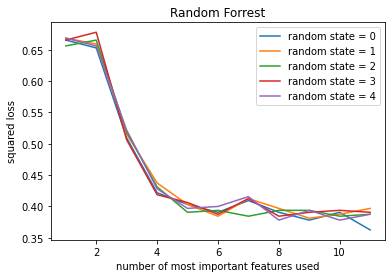

In [173]:
x_axis = np.arange(1, len(ranked_features) + 1)
for i in range(len(random_states)):
    plt.plot(x_axis,square_loss_matrix[i], label=f"random state = {i}")
plt.xlabel("number of most important features used")
plt.ylabel("squared loss")
plt.title("Random Forrest")
plt.legend()
plt.show()

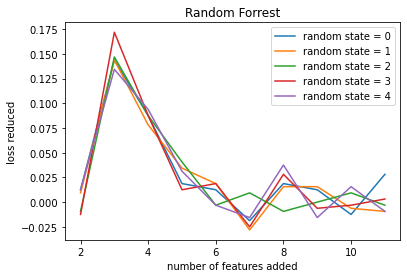

In [174]:
# squared loss difference
square_loss_matrix_0 = square_loss_matrix[:,:-1]
square_loss_matrix_1 = square_loss_matrix[:,1:]
square_loss_matrix_diff = square_loss_matrix_0 - square_loss_matrix_1

x_axis = np.arange(2, square_loss_matrix_diff.shape[1] + 2)
for i in range(len(random_states)):
    plt.plot(x_axis,square_loss_matrix_diff[i], label=f"random state = {i}")
plt.xlabel("number of features added")
plt.ylabel("loss reduced")
plt.title("Random Forrest")
plt.legend()
plt.show()


# Lasso Feature Selection

In [10]:
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import normalize

In [16]:
def select_feature(all_features, feature_filter):
    lst = []
    for i in range(len(feature_filter)):
        
        if feature_filter[i]:
            lst.append(all_features[i])
    return lst

n = 10
loss_lst = []
features_used = []
alphas = np.linspace(0.00001,0.008,30)
for a in alphas:
    # print(f"a = {a} =========")
    lasso_clf = linear_model.Lasso(alpha=a, normalize=True, random_state=1)
    lasso_clf.fit(train_x, train_y)
    feature_filter = ~np.isclose(lasso_clf.coef_, 0)
    selected_features = select_feature(train_x.columns, feature_filter)
    print(selected_features)
    y_pred = lasso_clf.predict(test_x)
    loss = square_loss(test_y, y_pred)
    loss_lst.append(loss)
    features_used.append(np.sum(feature_filter))
    # print(f"loss = {loss}")

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']
['fixed acidity', 'volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['fixed acidity', 'volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile a

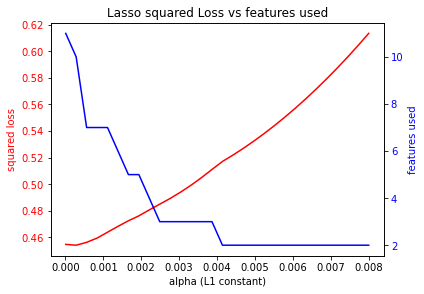

In [17]:
fig, ax1 = plt.subplots()

color = 'red'
ax1.set_xlabel('alpha (L1 constant)')
ax1.set_ylabel('squared loss', color=color)
ax1.plot(alphas, loss_lst, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('features used', color=color)  # we already handled the x-label with ax1
ax2.plot(alphas, features_used, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Lasso squared Loss vs features used")

plt.show()

In [310]:
train_x.columns.shape

(11,)